# Imports and utility variables

In [1]:
import phoebe
from phoebe import u

import numpy as np
import matplotlib.pyplot as plt

import scienceplots
plt.style.use("science")

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[1].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
import analisis.phoebe_model.optimizers.opt_utils as opt_utils
importlib.reload(gen_utils)
importlib.reload(opt_utils)

logger = phoebe.logger(clevel='WARNING')

In [2]:
gaiaDatasets = ['lcGaiaG', 'lcGaiaRP', 'lcGaiaBP']
ztfDatasets = ['lcZtfG', 'lcZtfR']

# Load post-optimizers model

In [3]:
b = gen_utils.loadBundle(bundleName="sigma_cleaned_ztf_updated_data", parentFolder="./sampling")

In [7]:
# adding line profile dataset to check SED
b.add_dataset('lp', compute_phases=phoebe.linspace(-0.5, 0.5, 21), wavelengths=phoebe.get_passband("Gaia:BP").ptf_table['wl']*u.m, dataset='lpGaiaBP', passband='Gaia:BP', overwrite=True)
b.add_dataset('lp', compute_phases=phoebe.linspace(-0.5, 0.5, 21), wavelengths=phoebe.get_passband("Gaia:RP").ptf_table['wl']*u.m, dataset='lpGaiaRP', passband='Gaia:RP', overwrite=True)

gen_utils.abilitateDatasets(b, ['lpGaiaBP', 'lpGaiaRP'], False)
b.run_compute(model='lp_model', overwrite=True)

Tue, 20 Aug 2024 18:37 BUNDLE       WARNING 'syn' not a recognized kwarg
Tue, 20 Aug 2024 18:37 BUNDLE       WARNING 'syn' not a recognized kwarg
100%|██████████| 21/21 [00:07<00:00,  2.77it/s]


<ParameterSet: 45 parameters | datasets: lpGaiaRP, lpGaiaBP>

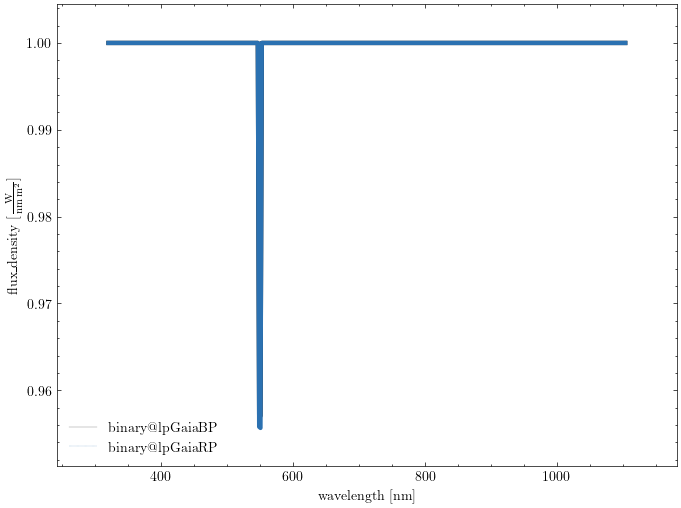

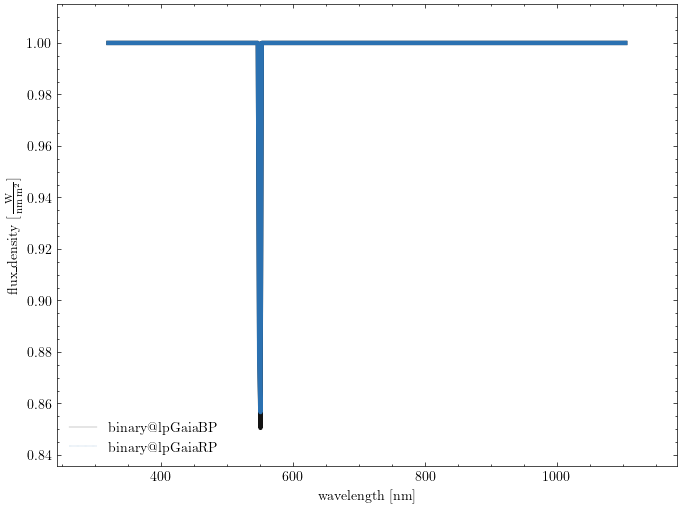

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [11]:
b.plot(show=True, model='lp_model', kind='lp', legend=True, phase=0, s=0.001)
b.plot(show=True, model='lp_model', kind='lp', legend=True, phase=0.25, s=0.001)

# Remove all datasets except for Gaia

Only Gaia datasets have support for interstellar extinction in passband files.